# Article Mimic
In this project, I will implement a LSTM RNN on texts, to generate a new article mimicing some given article inputs.

## Environment Setting

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from src.rnn import *
from src.rnn_layers import *
from src.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from src.data_utils import *
from src.rnn_solver import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preperation

In [13]:
filename = './data/csit6000I/collection-100'
N = 100
print('split by word:')
data, word_to_idx, idx_to_word = load_data(filename, N, mode='word')
print(data, len(word_to_idx), len(idx_to_word))



split by word:
[[   3    4    5 ...    0    0    0]
 [  39   21    6 ...    0    0    0]
 [  32   33   34 ...    0    0    0]
 ...
 [ 280 1144   47 ...    0    0    0]
 [1151 1159 1160 ...    0    0    0]
 [1161   12    8 ...    0    0    0]] 1185 1185


## LSTM
For introduction on this version of implementation of LSTM, see https://github.com/neilsun2009/cs231n-2018/blob/master/assignment3/LSTM_Captioning.ipynb.

### LSTM: step forward

In [14]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131185818695e-09
next_c error:  5.8143123088804145e-09


### LSTM: step backward

In [15]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  6.141176401368906e-10
dh error:  3.3953235055372503e-10
dc error:  1.5221723979041107e-10
dWx error:  1.6933643922734908e-09
dWh error:  2.5561308517943814e-08
db error:  1.7349247160222088e-10


### LSTM: forward

In [16]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


### LSTM: backward

In [17]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.82504980953228e-09
dh0 error:  7.500898788574784e-09
dWx error:  1.751994908422919e-09
dWh error:  1.085376964509146e-06
db error:  7.427550110055494e-10


### LSTM model

In [18]:
N, D, W, H = 10, 20, 30, 40
word_to_idx_tem = {'<NULL>': 0, 'cat': 2, 'dog': 3}
idx_to_word_tem = ['<NULL>', '', 'cat', 'dog']
V = len(word_to_idx_tem)
T = 13

model = RNN(word_to_idx_tem,
          idx_to_word_tem,
          wordvec_dim=W,
          hidden_dim=H,
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

texts = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(texts)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.793451649254596
expected loss:  9.82445935443
difference:  0.03100770517540319


### LSTM: training

(Iteration 1 / 200) loss: 313.142982
(Iteration 11 / 200) loss: 271.495987
(Iteration 21 / 200) loss: 283.145129
(Iteration 31 / 200) loss: 290.786491
(Iteration 41 / 200) loss: 248.597329
(Iteration 51 / 200) loss: 325.699087
(Iteration 61 / 200) loss: 246.448977
(Iteration 71 / 200) loss: 281.899826
(Iteration 81 / 200) loss: 280.408321
(Iteration 91 / 200) loss: 254.042196
(Iteration 101 / 200) loss: 296.150379
(Iteration 111 / 200) loss: 273.935544
(Iteration 121 / 200) loss: 224.860551
(Iteration 131 / 200) loss: 275.869910
(Iteration 141 / 200) loss: 257.795633
(Iteration 151 / 200) loss: 293.223827
(Iteration 161 / 200) loss: 290.029481
(Iteration 171 / 200) loss: 259.707954
(Iteration 181 / 200) loss: 289.952989
(Iteration 191 / 200) loss: 256.064483


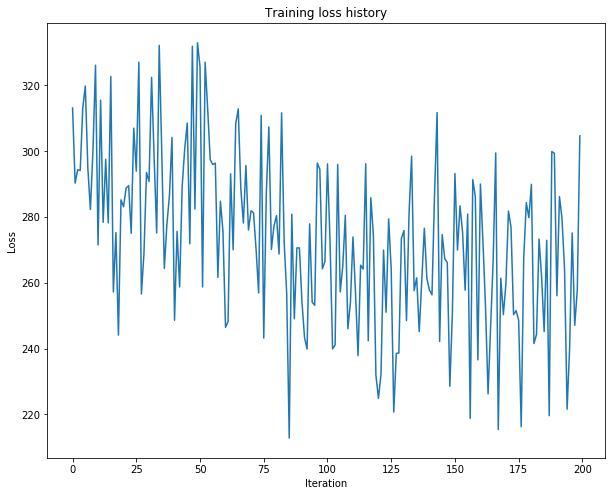

In [19]:
rnn_model = RNN(
          idx_to_word=idx_to_word,
          word_to_idx=word_to_idx,
          hidden_dim=128,
          wordvec_dim=128,
        )

rnn_solver = RNNSolver(rnn_model, data,
           update_rule='sgd',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-2,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

rnn_solver.train()

# Plot the training losses
plt.plot(rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

### Test

In [20]:
output_raw = rnn_model.sample(10)
output_texts = idx_to_article(output_raw, idx_to_word, 'word')
# output
# outputs = []
# for i in range(N):
#     outputs.append(' '.join([starts[i]] if keep_tag else starts[i][1:]) + texts[i])
for i in range(10):
    print(output_texts[i])

gauge believed facilities almost Test among market 337 Liquor put Argentine Brown cash Express worldwide Inns ended acquire merger stake programs national financial show announcement build arroba Again municipalities purchase form last 3 , july 

 351 expect representatives forecasts 790 Comissaria Reuters authorized Arsenio cost believed affected have Chairman coincidental 55 Partners February sources America well service holdings formally 31 holders official conversion times Organization dilution principle reduce selling specific 23 worldwide Prior Pacific No held seven holders effective common introduced reaction least Health 337 Company ) recommendations 
with for 345 sorghum minimizing two-for-one common price Foods solicitation English unwillingness Mattress 13 Joseph Brown Bu-Sorghum Argentine June ." inventory licensees quickly Destinations significant matured Pacific implementing derive debt-rescheduling Systems national 50 times we joint receives deposits announcement co-spon

### Test on letters

In [ ]:
# letter
filename = './data/bogo-html/bogo-html'
N = 11
print('split by letter:')
data, word_to_idx, idx_to_word = load_data(filename, N, mode='letter')
# data = np.array(data[:,:500])
print(data.shape)
print(data, len(word_to_idx), len(idx_to_word))

# train
rnn_model = RNN(
          idx_to_word=idx_to_word,
          word_to_idx=word_to_idx,
          hidden_dim=128,
          wordvec_dim=128,
        )

rnn_solver = RNNSolver(rnn_model, data,
           update_rule='sgd',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 1e-2,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

rnn_solver.train()

# Plot the training losses
plt.plot(rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# test
output_raw = rnn_model.sample(10)
output_texts = idx_to_article(output_raw, idx_to_word, 'word')
# output
# outputs = []
# for i in range(N):
#     outputs.append(' '.join([starts[i]] if keep_tag else starts[i][1:]) + texts[i])
for i in range(10):
    print(output_texts[i])

split by letter:
(11, 12977)
[[ 3  4  5 ...  5  6 18]
 [ 3  4  5 ...  0  0  0]
 [ 3  4  5 ...  0  0  0]
 ...
 [ 3 23 11 ...  0  0  0]
 [ 3  4  5 ...  0  0  0]
 [ 3  4  5 ...  0  0  0]] 95 95
(Iteration 1 / 50) loss: 11722.503511
